<a href="https://colab.research.google.com/github/kridtapon/Monte-carlo-Simulation-for-Trend-Power-SMA-ADX-/blob/main/Monte_carlo_Simulation_for_Trend_Power_(SMA%2BADX).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
<ipython-input-8-562d09a5a9a1>:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_final_profit = buy_and_hold_value[-1] - initial_cash


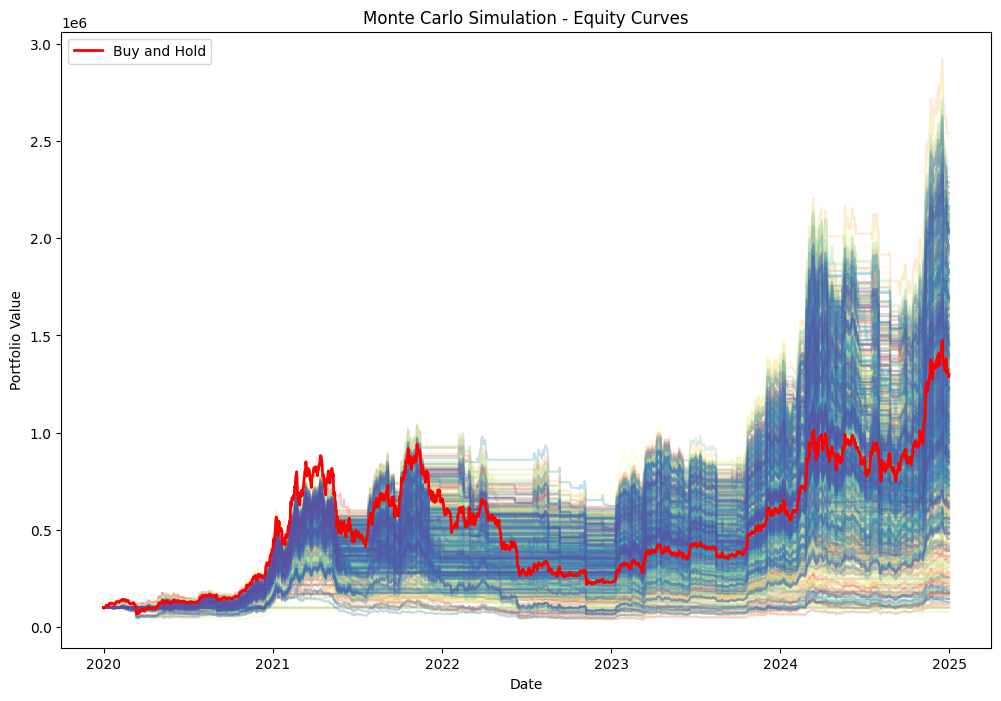

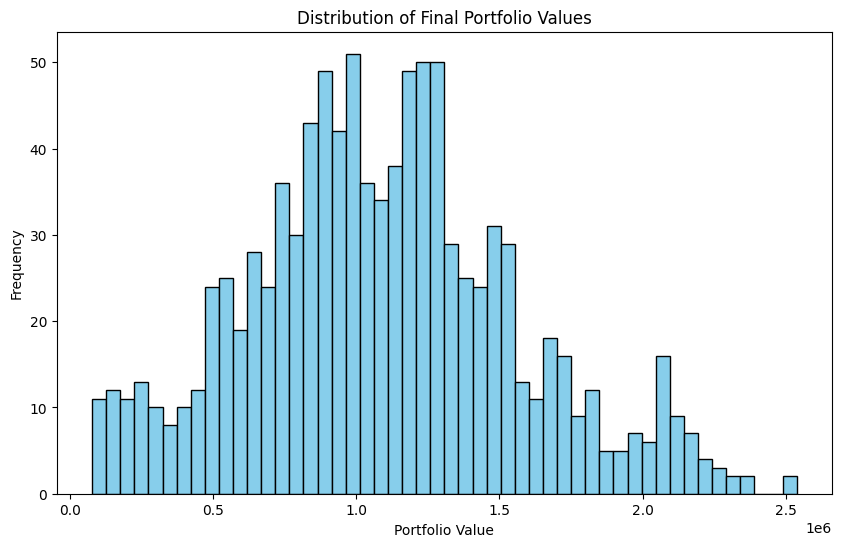

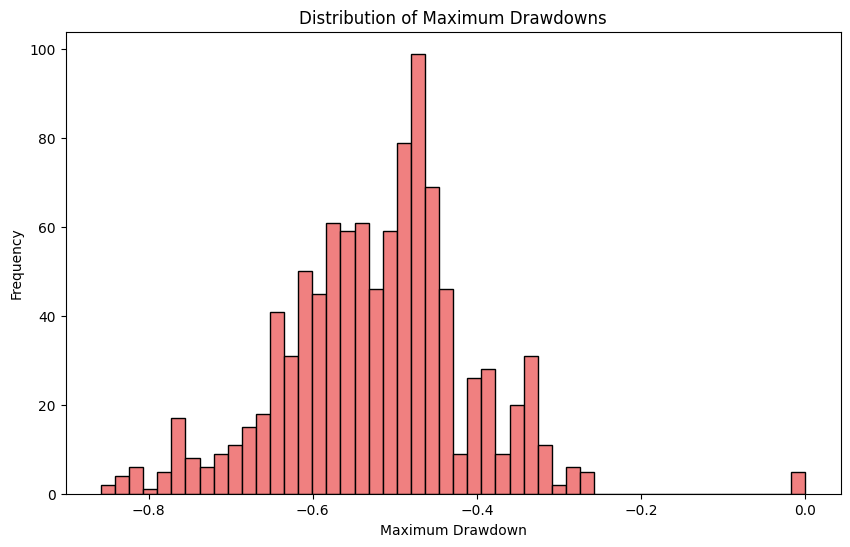

Mean Profit: 1090721.4631690665
Median Profit: 1069812.1724805743
Standard Deviation of Profit: 472221.3760263714
Buy and Hold Final Profit: 1197596.4055774745


In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate SMA
def calculate_sma(df, period):
    df['SMA'] = df['Close'].rolling(window=period).mean()
    return df

# Function to calculate ADX
def calculate_adx(df, period):
    df['TR'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['+DI'] = (df['+DM'].rolling(window=period).mean() / df['TR_smoothed']) * 100
    df['-DI'] = (df['-DM'].rolling(window=period).mean() / df['TR_smoothed']) * 100
    df['DX'] = abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']) * 100
    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define stock and date range
symbol = 'BTC-USD'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Monte Carlo Simulation
num_simulations = 1000
initial_cash = 100_000
fees = 0.001
simulation_results = []
equity_curves = []
max_drawdowns = []

# Perform simulations
for i in range(num_simulations):
    # Randomize parameters
    adx_period = np.random.randint(1, 51)   # ADX calculation period
    sma_period = np.random.randint(1, 201)  # SMA calculation period
    adx_threshold = np.random.uniform(1, 51)  # ADX threshold

    # Calculate indicators
    df = calculate_adx(df.copy(), adx_period)
    df = calculate_sma(df.copy(), sma_period)

    # Define entry and exit signals
    df['Entry'] = (df['ADX'] > adx_threshold) & (df['Close'] > df['SMA'])
    df['Exit'] = (df['ADX'] > adx_threshold) & (df['Close'] < df['SMA'])

    # Backtest
    cash = initial_cash
    position = 0
    equity_curve = []

    # Iterate through the DataFrame indices
    for idx in range(1, len(df)):
        if df['Entry'].iloc[idx] and cash > 0:
            position = cash / df['Close'].iloc[idx]  # Buy full position
            cash = 0
        elif df['Exit'].iloc[idx] and position > 0:
            cash = position * df['Close'].iloc[idx]  # Sell position
            position = 0
        equity_curve.append(cash + (position * df['Close'].iloc[idx]))

    equity_curve = np.array(equity_curve)
    simulation_results.append(equity_curve[-1])
    equity_curves.append(equity_curve)

    # Max drawdown
    drawdowns = equity_curve / np.maximum.accumulate(equity_curve) - 1
    max_drawdowns.append(drawdowns.min())

# Analyze results
simulation_results = np.array(simulation_results)
mean_profit = np.mean(simulation_results)
median_profit = np.median(simulation_results)
std_dev_profit = np.std(simulation_results)

# Buy-and-Hold strategy
buy_and_hold_value = initial_cash * (df['Close'] / df['Close'].iloc[0])

# Buy-and-Hold final profit
buy_and_hold_final_profit = buy_and_hold_value[-1] - initial_cash

# Plot results
plt.figure(figsize=(12, 8))

# Plot all equity curves
colors = sns.color_palette("Spectral", num_simulations)
for i, equity_curve in enumerate(equity_curves):
    plt.plot(df.index[1:], equity_curve, alpha=0.3, color=colors[i % len(colors)])

# Plot Buy-and-Hold curve
plt.plot(df.index, buy_and_hold_value, color='red', label='Buy and Hold', linewidth=2)

# Chart customization
plt.title('Monte Carlo Simulation - Equity Curves')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Plot histogram of profits
plt.figure(figsize=(10, 6))
plt.hist(simulation_results, bins=50, edgecolor='k', color='skyblue')
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of drawdowns
plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns, bins=50, edgecolor='k', color='lightcoral')
plt.title('Distribution of Maximum Drawdowns')
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')
plt.show()

# Print the results
print(f"Mean Profit: {mean_profit}")
print(f"Median Profit: {median_profit}")
print(f"Standard Deviation of Profit: {std_dev_profit}")
print(f"Buy and Hold Final Profit: {buy_and_hold_final_profit}")